In [1]:
import os
import glob

import cv2
import numpy as np
import matplotlib.pyplot as plt

import fiftyone as fo

from benthic_mapping.download_media import MediaDownloader
from benthic_mapping.fiftyone_clustering import FiftyOneDatasetViewer
from benthic_mapping.download_labeled_data import LabeledDataDownloader

# Download Media (frames) from Tator

In [2]:
# Initialize the downloader with the required parameters
downloader = MediaDownloader(
    api_token=os.getenv("TATOR_TOKEN"),
    project_id=155,
    output_dir="../Data"
)

# Download the media
media_ids = ["14759824"]
downloader.download_data(media_ids, 
                         convert=False, 
                         extract=True, 
                         every_n_seconds=3)

NOTE: Authentication successful for jordan.pierce
NOTE: Media GL2301_VID_20230725T145731Z_D015_DROPCAM_HIGH.mp4 downloaded successfully to ../Data\Raw_Videos\GL2301_VID_20230725T145731Z_D015_DROPCAM_HIGH_converted.mp4
NOTE: Extracting frames from GL2301_VID_20230725T145731Z_D015_DROPCAM_HIGH.mp4...
Video duration: 381.88 seconds
Extracting 127 frames using 16 workers...
Successfully extracted 127 frames to ../Data\Extracted_Frames\GL2301_VID_20230725T145731Z_D015_DROPCAM_HIGH_converted


['../Data\\Raw_Videos\\GL2301_VID_20230725T145731Z_D015_DROPCAM_HIGH_converted.mp4']

In [3]:
downloader.media_path_map

{'14759824': {'original': '../Data\\Raw_Videos\\GL2301_VID_20230725T145731Z_D015_DROPCAM_HIGH_converted.mp4',
  'converted': None,
  'frames': '../Data\\Extracted_Frames\\GL2301_VID_20230725T145731Z_D015_DROPCAM_HIGH_converted'}}

# View Clustered Frames from Tator using Fiftyone

In [4]:
# Initialize the viewer with the path to the directory containing images
viewer = FiftyOneDatasetViewer(image_dir=downloader.media_path_map['14759824']['frames'])

# Process the dataset to create the FiftyOne dataset and generate the UMAP visualization
viewer.process_dataset()

Overwriting existing dataset: GL2301_VID_20230725T145731Z_D015_DROPCAM_HIGH_converted


Processing images: 100%|██████████| 127/127 [00:06<00:00, 20.27it/s]

   1% ||----------------|   1/127 [18.3ms elapsed, 2.3s remaining, 54.8 samples/s] 

 100% |█████████████████| 127/127 [99.4ms elapsed, 0s remaining, 1.3K samples/s]   
Computing embeddings...
Computing UMAP visualization...
Generating visualization...


c:\Users\jordan.pierce\.conda\envs\bm\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\jordan.pierce\.conda\envs\bm\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP(n_jobs=1, random_state=51, verbose=True)
Fri Feb 28 23:04:42 2025 Construct fuzzy simplicial set
Fri Feb 28 23:04:43 2025 Finding Nearest Neighbors
Fri Feb 28 23:04:50 2025 Finished Nearest Neighbor Search
Fri Feb 28 23:04:54 2025 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Fri Feb 28 23:04:55 2025 Finished embedding


In [ ]:
# Launch the FiftyOne app
try:
    session = fo.launch_app(viewer.dataset)
except:
    session = fo.launch_app(viewer.dataset)

# Download Labeled Data from Tator

In [2]:
# Set parameters
api_token = os.getenv("TATOR_TOKEN")
project_id = 155  # 70

# Search string comes from Tator's Data Metadata Export utility
search_string = "eyJtZXRob2QiOiJBTkQiLCJvcGVyYXRpb25zIjpbeyJtZXRob2QiOiJPUiIsIm9wZXJhdGlvbnMiOlt7ImF0dHJpYnV0ZSI6IiR0eXBlIiwib3BlcmF0aW9uIjoiZXEiLCJpbnZlcnNlIjpmYWxzZSwidmFsdWUiOjQ2MH0seyJhdHRyaWJ1dGUiOiIkdHlwZSIsIm9wZXJhdGlvbiI6ImVxIiwiaW52ZXJzZSI6ZmFsc2UsInZhbHVlIjo1NTN9XX1dfQ=="

# Demo for downloading labeled data
frac = 1.0

dataset_name = "AUV_Polygons"
output_dir = "../Data/Labeled_Data"

label_field = "Label"

In [3]:
# Create a downloader for the labeled data
downloader = LabeledDataDownloader(api_token,
                                   project_id=project_id,
                                   search_string=search_string,
                                   frac=frac,
                                   output_dir=output_dir,
                                   dataset_name=dataset_name,
                                   label_field=label_field)

NOTE: Authentication successful for jordan.pierce
NOTE: Search string saved to e:\Benthic-Mapping\Data\Labeled_Data\AUV_Polygons\search_string.txt


In [4]:
# Download the labeled data
downloader.download_data()

NOTE: Querying Tator for labeled data
NOTE: Found 8645 localizations


Processing Query: 100%|██████████| 8645/8645 [00:00<00:00, 9436.80it/s]


NOTE: Found 8645 localizations after sampling
NOTE: Data saved to e:\Benthic-Mapping\Data\Labeled_Data\AUV_Polygons\data.json
NOTE: Downloading images to e:\Benthic-Mapping\Data\Labeled_Data\AUV_Polygons\images


NOTE: Images downloaded to e:\Benthic-Mapping\Data\Labeled_Data\AUV_Polygons\images


In [5]:
downloader.data  # .data_dict

,media,frame,image_name,image_path,label_name,x,y,width,height,polygon,label
0,16814883,0,16814883_0.jpg,e:\Benthic-Mapping\Data\Labeled_Data\AUV_Polyg...,16814883_0.txt,0.512695,0.218000,0.519287,0.229000,"[[0.51416015625, 0.21833333333333332], [0.5129...",None
1,16814812,0,16814812_0.jpg,e:\Benthic-Mapping\Data\Labeled_Data\AUV_Polyg...,16814812_0.txt,0.761475,0.911000,0.770020,0.924000,"[[0.767578125, 0.911], [0.763916015625, 0.9113...",None
2,16814894,0,16814894_0.jpg,e:\Benthic-Mapping\Data\Labeled_Data\AUV_Polyg...,16814894_0.txt,0.757812,0.613000,0.764404,0.623667,"[[0.762939453125, 0.6133333333333333], [0.7602...",None
3,16814894,0,16814894_0.jpg,e:\Benthic-Mapping\Data\Labeled_Data\AUV_Polyg...,16814894_0.txt,0.594971,0.728000,0.604980,0.742333,"[[0.59619140625, 0.7286666666666667], [0.59521...",None
4,16814870,0,16814870_0.jpg,e:\Benthic-Mapping\Data\Labeled_Data\AUV_Polyg...,16814870_0.txt,0.751465,0.318000,0.757568,0.328333,"[[0.756103515625, 0.318], [0.752685546875, 0.3...",None
...,...,...,...,...,...,...,...,...,...,...,...
8640,16819177,0,16819177_0.jpg,e:\Benthic-Mapping\Data\Labeled_Data\AUV_Polyg...,16819177_0.txt,0.765381,0.645667,0.770752,0.656000,"[[0.767822265625, 0.6456666666666667], [0.7653...",None
8641,16809170,0,16809170_0.jpg,e:\Benthic-Mapping\Data\Labeled_Data\AUV_Polyg...,16809170_0.txt,0.594482,0.090333,0.626465,0.134333,"[[0.60302734375, 0.09033333333333333], [0.5996...",None
8642,16809170,0,16809170_0.jpg,e:\Benthic-Mapping\Data\Labeled_Data\AUV_Polyg...,16809170_0.txt,0.602539,0.065000,0.640869,0.127000,"[[0.607177734375, 0.065], [0.602783203125, 0.0...",None
8643,16809170,0,16809170_0.jpg,e:\Benthic-Mapping\Data\Labeled_Data\AUV_Polyg...,16809170_0.txt,0.641357,0.601000,0.706055,0.676667,"[[0.704345703125, 0.608], [0.6962890625, 0.602...",None


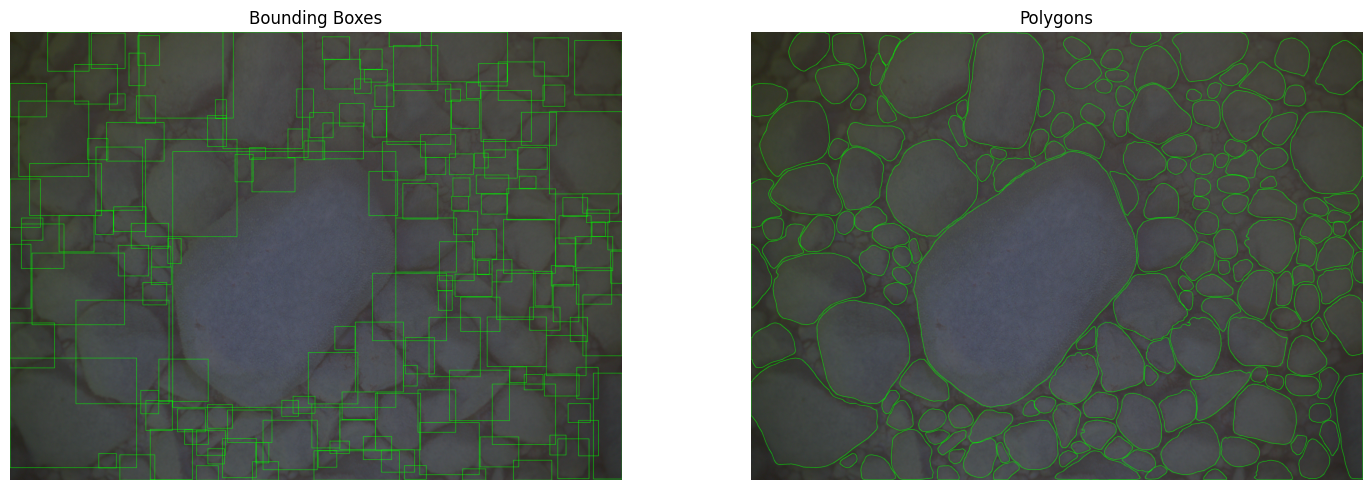

In [16]:
# Grab a random image and its polygons
df = downloader.data[downloader.data["image_name"] == downloader.data.sample(1)["image_name"].values[0]]
polygons = df[['polygon']].values

# read the image
image = cv2.imread(df['image_path'].values[0])
image_with_boxes = image.copy()
image_with_polygons = image.copy()

# convert from normalized to pixel coordinates
height, width, _ = image.shape

for polygon in polygons:
    polygon = [[int(x * width), int(y * height)] for x, y in polygon[0]]
    polygon = np.array(polygon, np.int32)
    polygon = polygon.reshape((-1, 1, 2))
    
    # Draw polygon on the right image
    cv2.polylines(image_with_polygons, [polygon], isClosed=True, color=(0, 255, 0), thickness=2)
    
    # Draw only bounding box on the left image
    rect = cv2.boundingRect(polygon)
    cv2.rectangle(image_with_boxes, (rect[0], rect[1]), 
                 (rect[0] + rect[2], rect[1] + rect[3]), 
                 (0, 255, 0), 2)

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot image with bounding boxes
ax1.imshow(image_with_boxes)
ax1.set_title('Bounding Boxes')
ax1.axis('off')

# Plot image with polygons
ax2.imshow(image_with_polygons)
ax2.set_title('Polygons')
ax2.axis('off')

plt.tight_layout()
plt.show()